In [21]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
from IPython.display import display, HTML
from typing import List
import numpy as np
import matplotlib
import imodelsx.util
from copy import deepcopy
import re
# import sasc.notebook_helper
import sasc.viz
import scipy.special
from collections import defaultdict
from pprint import pprint
import joblib
# import viz
from sasc.config import RESULTS_DIR

MAIN_DIR = join(RESULTS_DIR, 'stories', 'interactions')
EXPT_DIRS = sorted([join(MAIN_DIR, dir_name) for dir_name in os.listdir(MAIN_DIR)])
EXPT_DIRS = [x for x in EXPT_DIRS if 'uts03' in x.lower() or 'uts01' in x.lower()]
EXPT_DIR = EXPT_DIRS[0]
rows = joblib.load(join(EXPT_DIR, f'rows.pkl'))
expls = rows.expl.values
try:
    prompts_paragraphs = joblib.load(
        join(EXPT_DIR, "prompts_paragraphs.pkl"),
    )
    prompts = prompts_paragraphs["prompts"]
    paragraphs = prompts_paragraphs["paragraphs"]
except:
    prompts = open(join(EXPT_DIR, "prompts.txt"), 'r').read().split('\n\n')
    paragraphs = open(join(EXPT_DIR, "story.txt"), 'r').read().split('\n\n')
    assert len(prompts) == len(paragraphs), f"{len(prompts)} != {len(paragraphs)}"
# voxel_nums = rows.module_num.values
# subjects = rows.subject.values

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Heatmaps

**Module** <> Story Heatmap

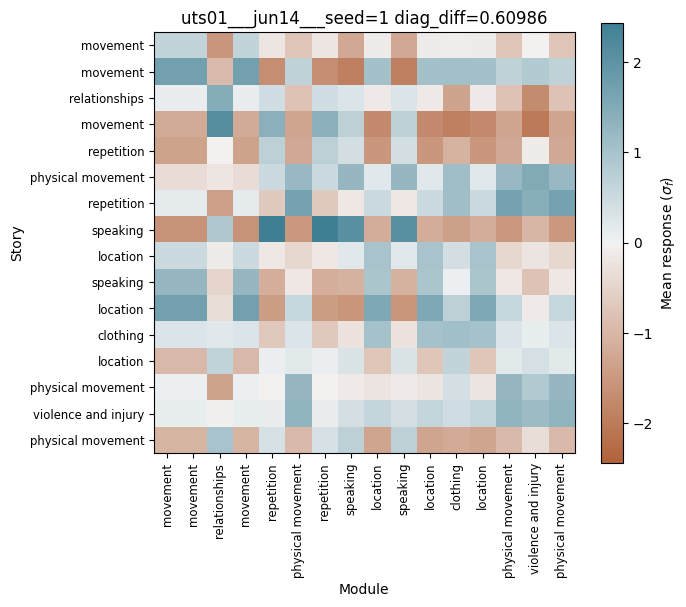

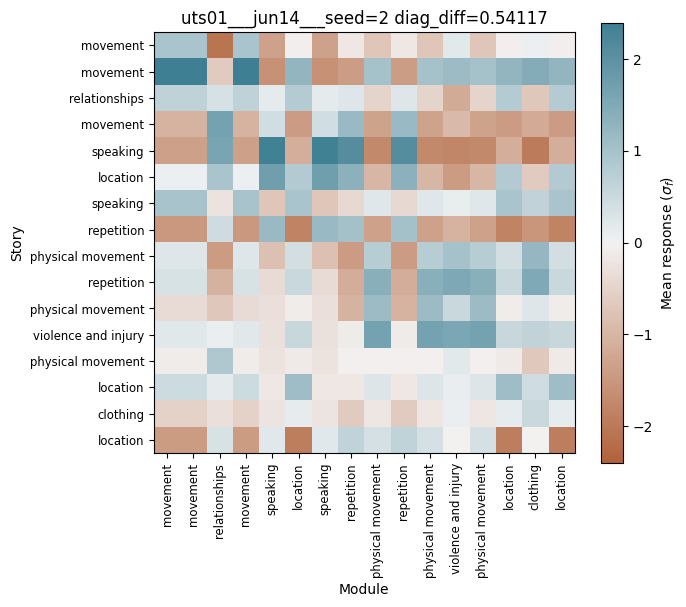

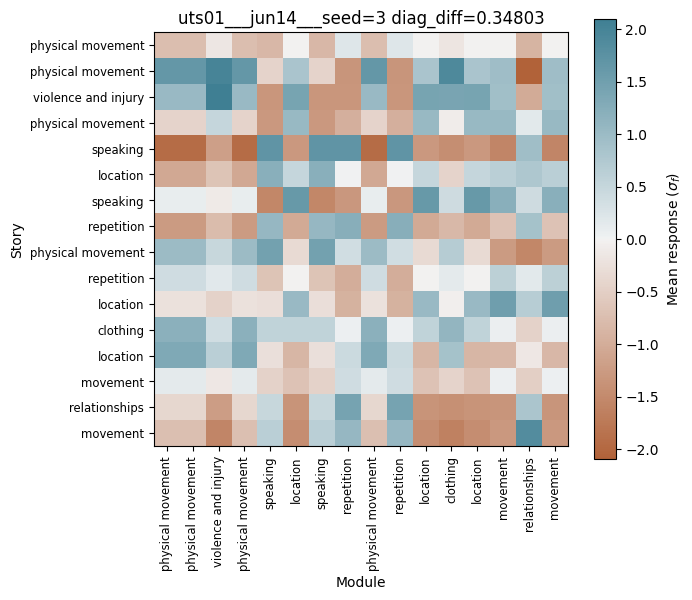

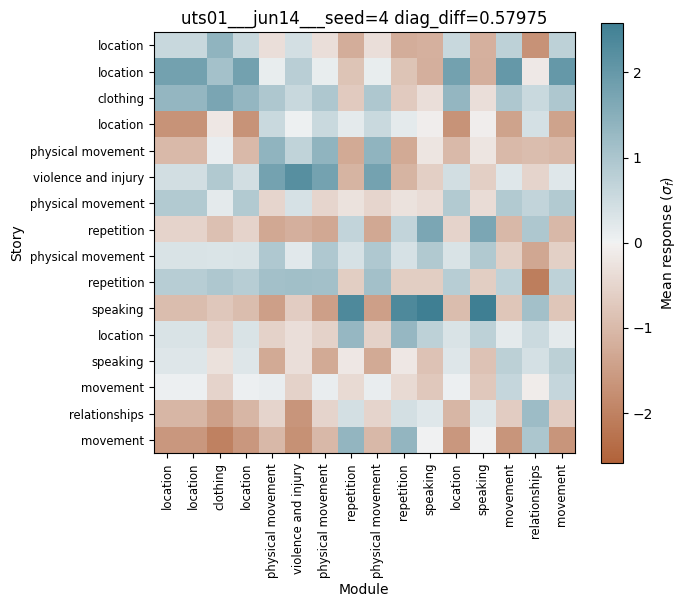

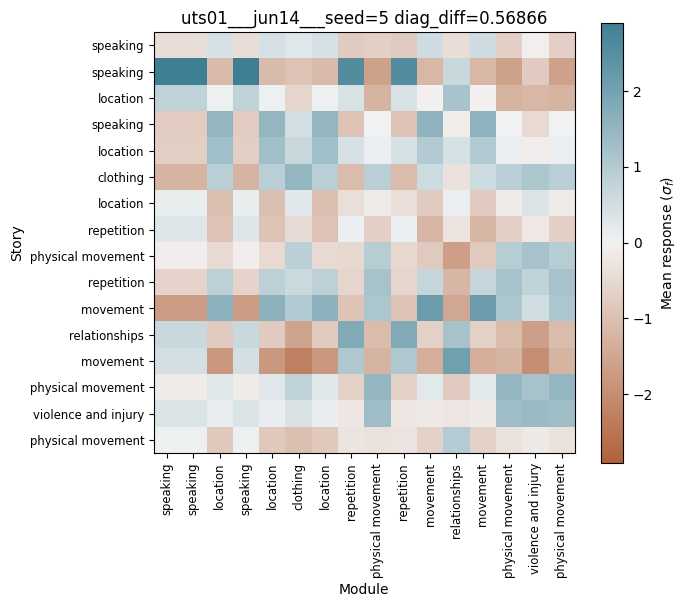

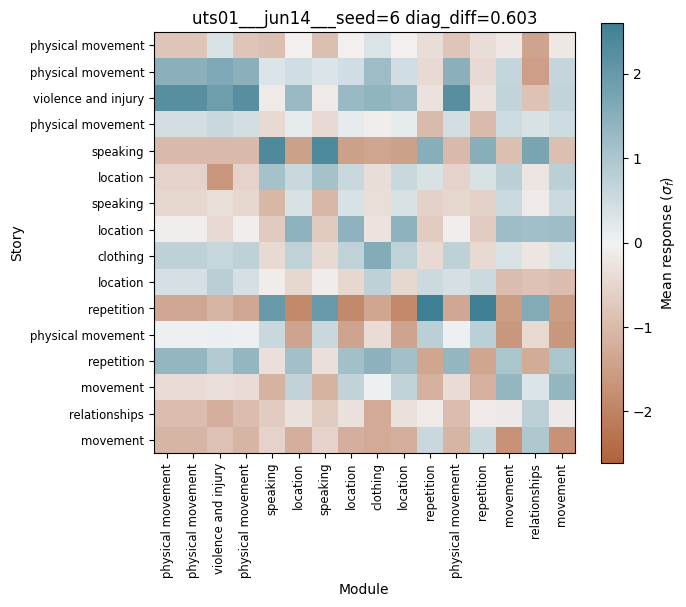

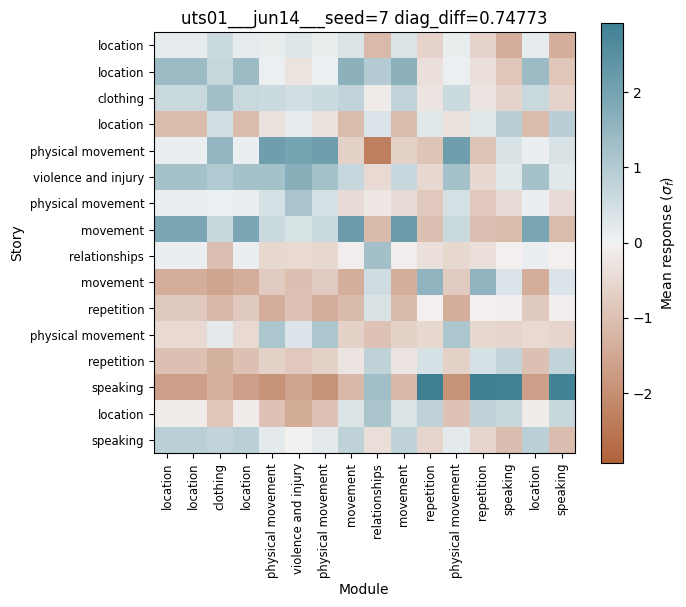

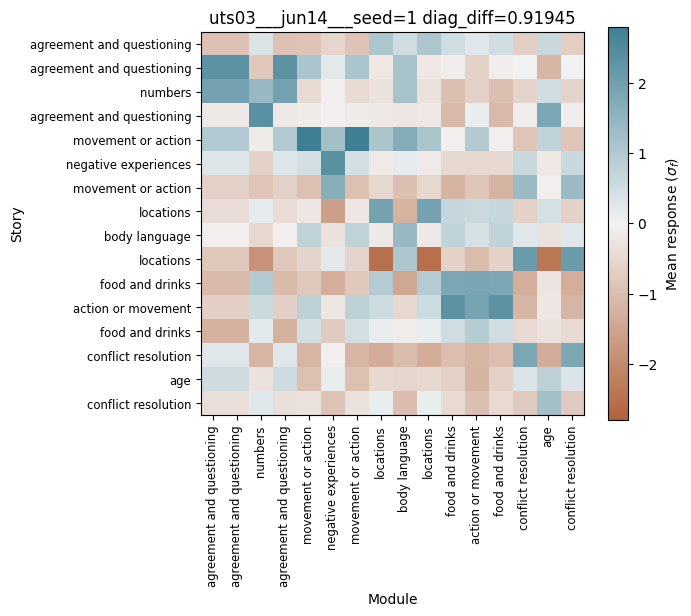

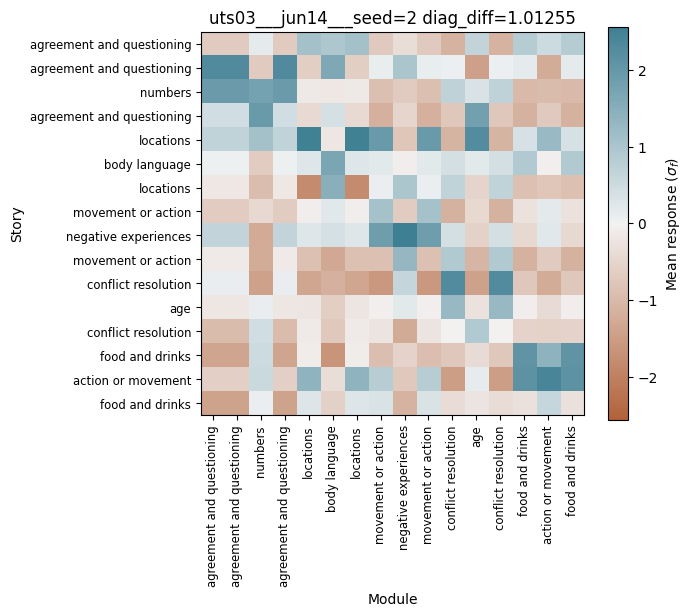

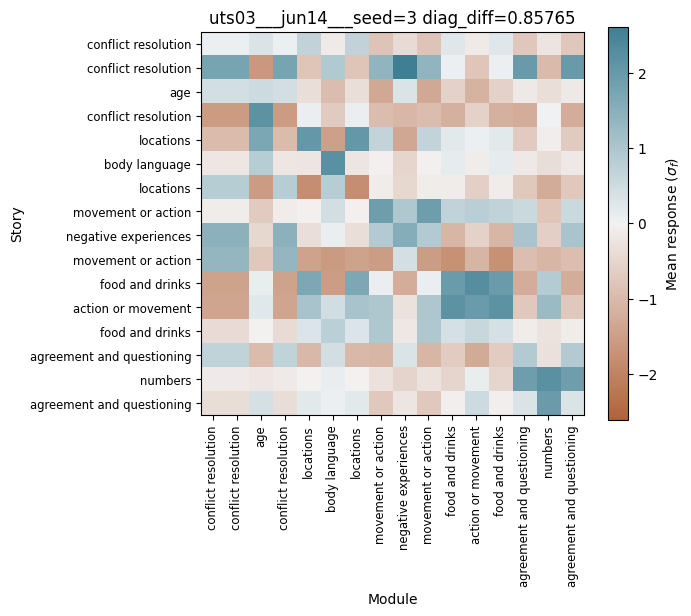

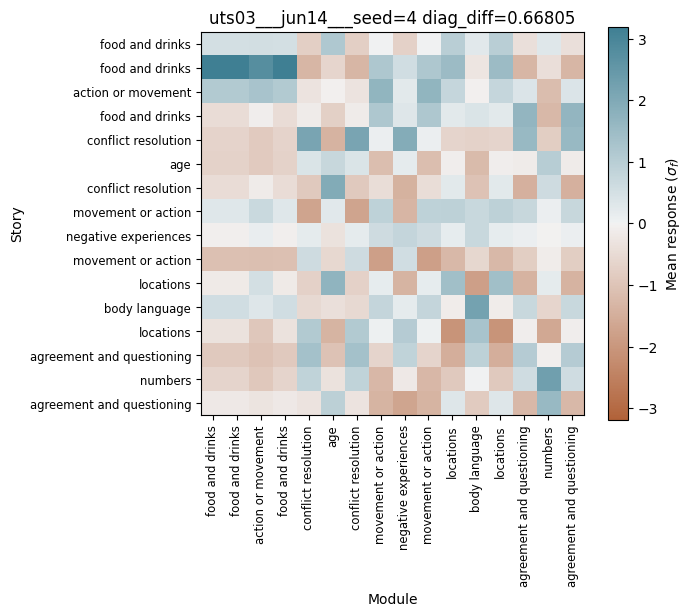

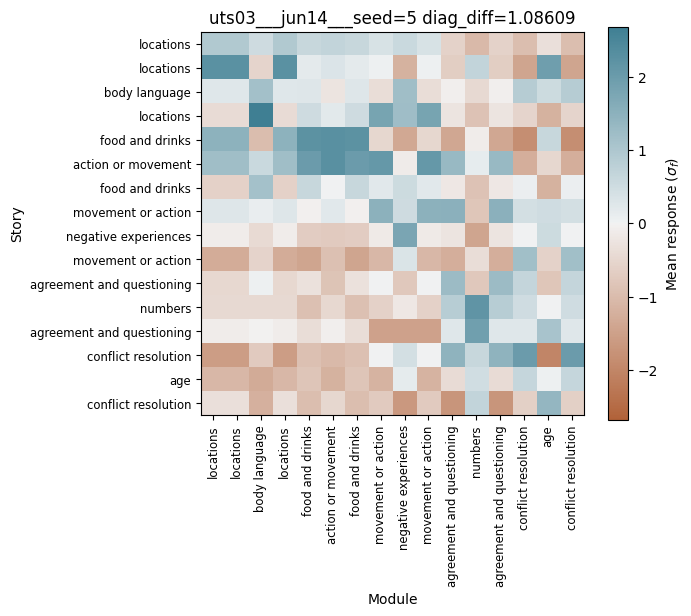

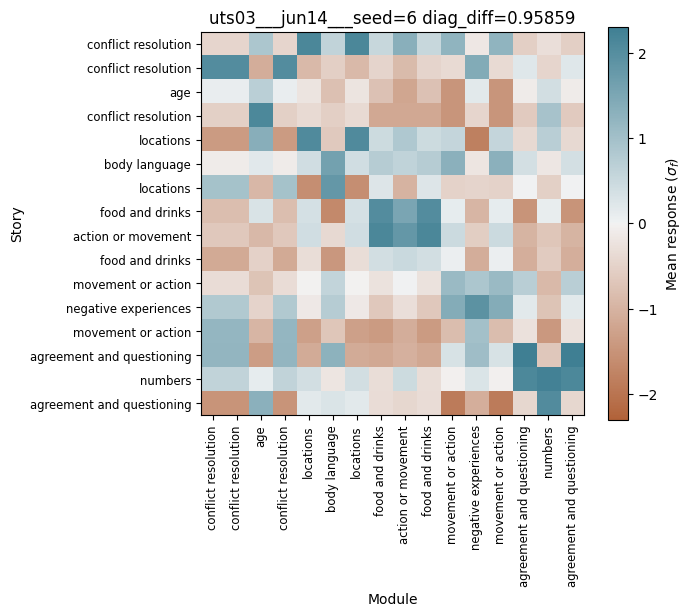

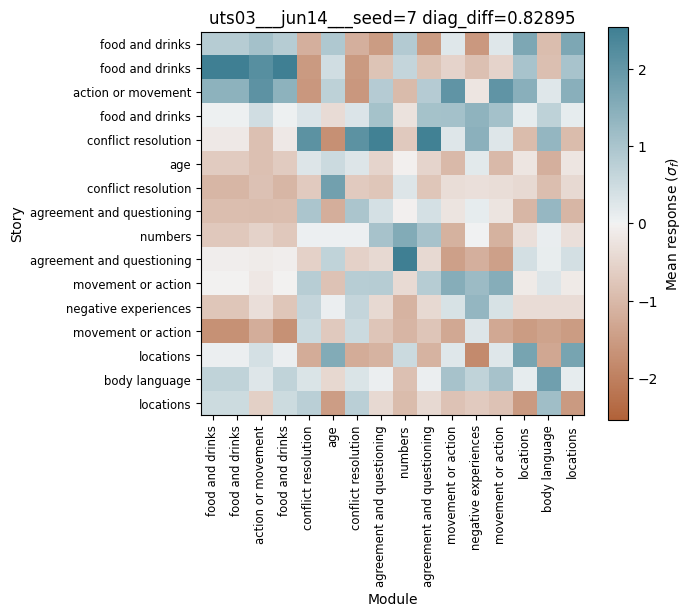

In [22]:
res = {}
for EXPT_DIR in EXPT_DIRS:
    scores_data = joblib.load(join(EXPT_DIR, f"scores_mod_ngram_length={0}.pkl"))
    s = scores_data["scores_mean"].T
    # z-score each column
    s = (s - s.mean(axis=0)) / s.std(axis=0)

    # s = scipy.special.softmax(s, axis=0)
    # s = (s - s.min()) / (s.max() - s.min())
    # rows = joblib.load(join(EXPT_DIR, f'rows1_rep.pkl'))
    rows = joblib.load(join(EXPT_DIR, f"rows.pkl"))
    expls = rows.expl.values
    sasc.viz.heatmap(s, expls, ylab="Story", xlab="Module")

    # calculate mean of diagonal - mean of off-diagonal for s
    diag_diff = (
        np.mean(np.diag(s))
        - (
            np.mean(s[np.triu_indices_from(s, k=1)])
            + np.mean(s[np.tril_indices_from(s, k=-1)])
        )
        / 2
    ).round(5)
    plt.title(os.path.basename(EXPT_DIR) + ' diag_diff=' + str(diag_diff))
    res[os.path.basename(EXPT_DIR)] = diag_diff

    plt.savefig(join(EXPT_DIR, f"story_module_match.png"), dpi=300)
    plt.savefig(join(EXPT_DIR, f"story_module_match.pdf"), bbox_inches="tight")
    # plt.tight_layout()
    # plt.show()
# sasc.viz.save_figs_to_single_pdf('../results/expl_story_match.pdf')

In [23]:
res

{'uts01___jun14___seed=1': 0.60986,
 'uts01___jun14___seed=2': 0.54117,
 'uts01___jun14___seed=3': 0.34803,
 'uts01___jun14___seed=4': 0.57975,
 'uts01___jun14___seed=5': 0.56866,
 'uts01___jun14___seed=6': 0.603,
 'uts01___jun14___seed=7': 0.74773,
 'uts03___jun14___seed=1': 0.91945,
 'uts03___jun14___seed=2': 1.01255,
 'uts03___jun14___seed=3': 0.85765,
 'uts03___jun14___seed=4': 0.66805,
 'uts03___jun14___seed=5': 1.08609,
 'uts03___jun14___seed=6': 0.95859,
 'uts03___jun14___seed=7': 0.82895}

**Module** <> Story Heatmap

In [ ]:
for EXPT_DIR in EXPT_DIRS[:1]:
    # keys: scores_mod, scores_max_mod, all_scores, all_ngrams
    # ngram_lengths = [10, 50, 100, 384]
    ngram_lengths = [0]
    for ngram_length in ngram_lengths:
        scores_mod_dict = joblib.load(join(EXPT_DIR, f'scores_mod_ngram_length={ngram_length}.pkl'))
        rows = joblib.load(join(EXPT_DIR, f'rows1_rep.pkl'))
        expls = rows.expl.values

        s = scores_mod_dict['scores_mean'].T
        s = scipy.special.softmax(s, axis=0)
        # s = (s - s.min()) / (s.max() - s.min())
        sasc.viz.heatmap(s, expls, ylab='Story', xlab='Module (fit to fMRI voxel)', clab='Mean module response')

        n = s.shape[0]
        # plt.plot([0, n], [0, n], '--', color='gray', alpha=0.1)
        plt.title(f'Model window: {ngram_length} words', fontsize='small')
        plt.savefig(join(EXPT_DIR, f'mod_story_match_ngram_length={ngram_length}.png'), dpi=300)
        plt.savefig(join(EXPT_DIR, f'mod_story_match_ngram_length={ngram_length}.png'), bbox_inches='tight')
        # plt.show()
# sasc.viz.save_figs_to_single_pdf('../results/expl_mod_match.pdf')

### Best voxels automated

In [ ]:
vox_diffs = defaultdict(list)
for EXPT_DIR in EXPT_DIRS:
    ngram_length = 0
    scores_mod_dict = joblib.load(join(EXPT_DIR, f'scores_mod_ngram_length={ngram_length}.pkl'))
    rows = joblib.load(join(EXPT_DIR, f'rows.pkl'))
    expls = rows.expl.values


    s = scores_mod_dict['scores_mean'].T
    s = scipy.special.softmax(s, axis=0)

    BLOCK_SIZE = 4
    for i in range(0, rows.shape[0]):
        row = rows.iloc[i]
        s_row = s[i]
        block_idxs = range((i // BLOCK_SIZE) * BLOCK_SIZE, (i // BLOCK_SIZE + 1) * BLOCK_SIZE)
        diff = s_row[i] - np.mean([s_row[j] for j in range(s_row.shape[0]) if j not in block_idxs])
        vox_diffs[(row.module_num, row.expl)].append(diff)
vox_diffs = {k: np.mean(v) for k, v in vox_diffs.items()}
vox_diffs

In [ ]:
# display all rows
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(pd.DataFrame(vox_diffs.items()).sort_values(1, ascending=False).head(30))